In [1]:
import xarray as xr
import glob
import netCDF4 as nc
import numpy as np
import socket
import json
import os
import sys
from datetime import datetime, timezone, timedelta
import xmitgcm as xm

import matplotlib.pyplot as plt

# Get the path to the parent folder (one level up)
parent_folder = os.path.abspath(os.path.join(os.getcwd(), '../..'))
print(parent_folder)

# Add the parent folder to sys.path
sys.path.append(parent_folder)
from mitgcm.utils_mitgcm import open_mitgcm_ds_from_config
#%matplotlib notebook
# seaborn for interactive plots or bokee or hvplot

/home/rasmusso@eawag.wroot.emp-eaw.ch/Documents/plot_results


In [2]:
model = 'test_zurich'
lake_name='Luzern'
mitgcm_config, ds_to_plot = open_mitgcm_ds_from_config('..//config.json', model)

In [4]:
ds_to_plot = ds_to_plot.isel(YG=range(0,64), YC=range(0,160))

In [3]:
ds_to_plot['time'][-1]

<xarray.DataArray 'time' ()> Size: 8B
array('2024-10-20T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    iter     int64 8B dask.array<chunksize=(), meta=np.ndarray>
    time     datetime64[ns] 8B 2024-10-20
Attributes:
    standard_name:  time
    long_name:      Time
    axis:           T

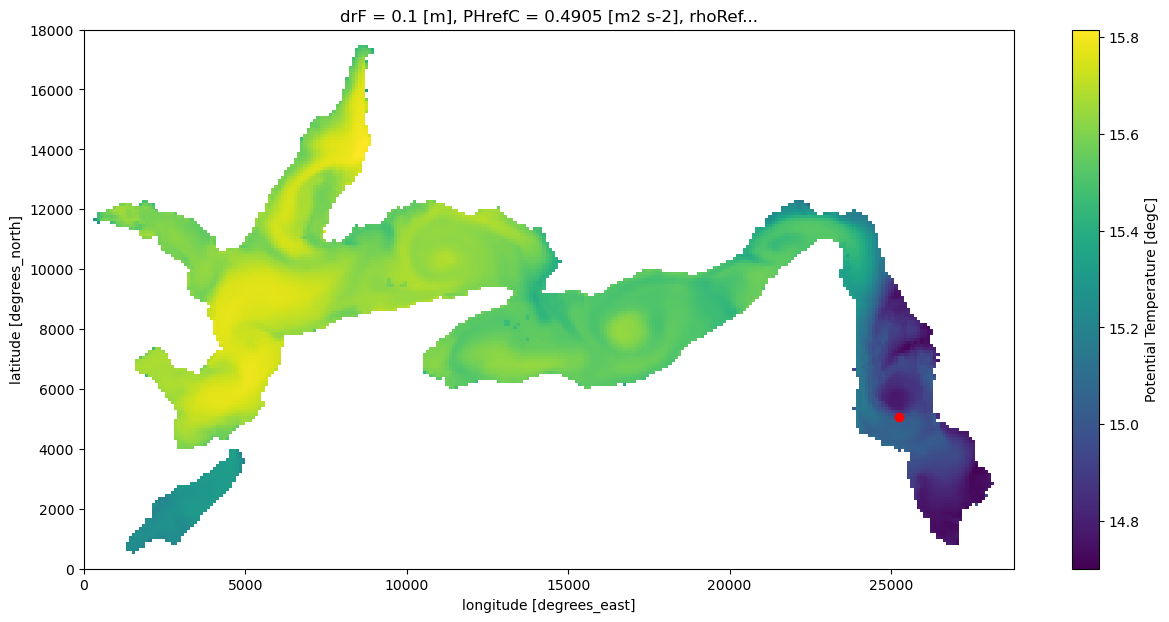

In [4]:
xc_mitgcm_station = 25231
yc_mitgcm_station = 5070

date_plot_profil = datetime(2024,3,4,0,0,0)
date_plot_profil_str = date_plot_profil.strftime('%Y%m%d%H%M')

#chose between ['UVEL', 'VVEL', 'WVEL', 'THETA', 'rA', ..., 'XG', 'YG', 'Zp1', 'Zu', 'Zl']
plt.close('all')
plt.figure(figsize=(15,7))
ds_sel = ds_to_plot['THETA'].isel(Z=0, time=-1)
ds_sel.where(ds_sel != 0, np.nan).plot()
plt.scatter(xc_mitgcm_station,yc_mitgcm_station,color='red')
plt.show()

In [56]:
ds_to_plot[var2].sel(XC=xc_mitgcm_station, YC=yc_mitgcm_station, Z=0, method='nearest')

<xarray.DataArray 'THETA' (time: 4519)> Size: 36kB
dask.array<getitem, shape=(4519,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates: (12/14)
    rA       >f4 4B dask.array<chunksize=(), meta=np.ndarray>
    Depth    >f4 4B dask.array<chunksize=(), meta=np.ndarray>
    drF      >f4 4B dask.array<chunksize=(), meta=np.ndarray>
    PHrefC   >f4 4B dask.array<chunksize=(), meta=np.ndarray>
    hFacC    >f4 4B dask.array<chunksize=(), meta=np.ndarray>
    maskC    bool 1B dask.array<chunksize=(), meta=np.ndarray>
    ...       ...
    dxF      >f4 4B dask.array<chunksize=(), meta=np.ndarray>
    iter     (time) int64 36kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) datetime64[ns] 36kB 2024-03-06T00:59:44 ... 2024-09-10T06...
    Z        float64 8B -0.05
    XC       float64 8B 8.15e+03
    YC       float64 8B 3.75e+03
Attributes:
    standard_name:  THETA
    long_name:      Potential Temperature
    units:          degC

In [7]:
#select the meteo input you wish to plot
var='atemp'
#select the corresponding result name
var2 = 'THETA'

bin_file_path = rf"/storage/alplakes_test/Soren/lake_lu/100m/march_oct_2024/binary_data/{var}.bin"
with open(bin_file_path, 'rb') as fid:
    binary_data = np.fromfile(fid, dtype='>f8')
grid_resolution = 100
grid_fact = grid_resolution / 50
nx =288
ny = 180
nt = len(binary_data) / nx /ny

from datetime import datetime, timedelta

start_date = datetime(2024, 3, 4)

date_list = []
for i in range(0, int(nt)):
    current_date = start_date + timedelta(hours=i)
    date_list.append(current_date)

bin_array = np.reshape(binary_data, (int(nt),int(ny),int(nx)))
i_time = -1


KeyError: "'XG' is not a valid dimension or coordinate for Dataset with dimensions FrozenMappingWarningOnValuesAccess({'YC': 160, 'XC': 288, 'Z': 80, 'time': 1983})"

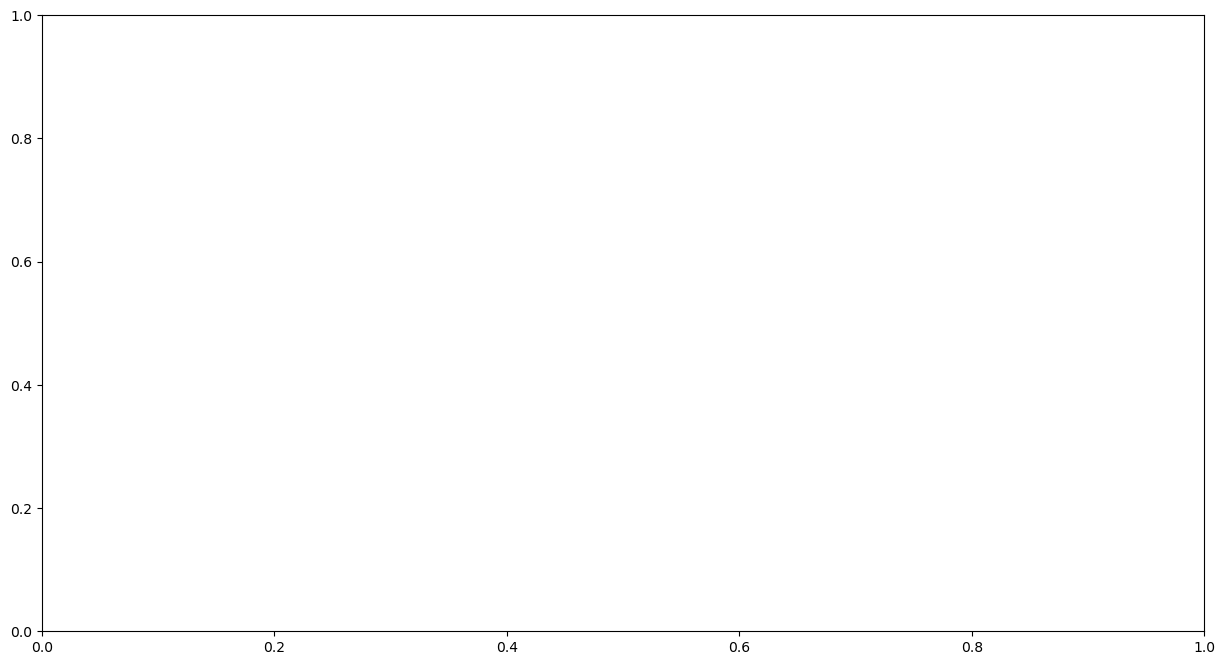

In [33]:
# FIGURE AIR VS WATER VELOCITY

plt.close('all')
fig, ax1 = plt.subplots(figsize=(15, 8))

# Plot water velocity on primary y-axis
ds_to_plot[var2].sel(XG=xc_mitgcm_station, YC=yc_mitgcm_station, Z=0, method='nearest').plot(
ax=ax1, color = "orange",label="Modeled wat. vel. at surface")

ax1.set_ylabel('Water velocity [m/s]', color='orange')
ax1.set_title("")
#ax1.set_ylim(-0.3, 0.6)
ax1.tick_params(axis='y', colors='orange')
ax1.grid(True, which='both', linewidth=0.3)

# Create secondary y-axis for wind speed
ax2 = ax1.twinx()
ax2.plot(date_list, bin_array[:, 19*2, 41*2], linestyle='-', color='black',alpha=0.3, label='Wind measurements')

ax2.set_ylabel('Wind velocity [m/s]', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Water vs air velocity at the Station Location',pad=20)
#plt.savefig(rf"{lake_name}_Vel_air_vs_wat_march.png")
plt.show()

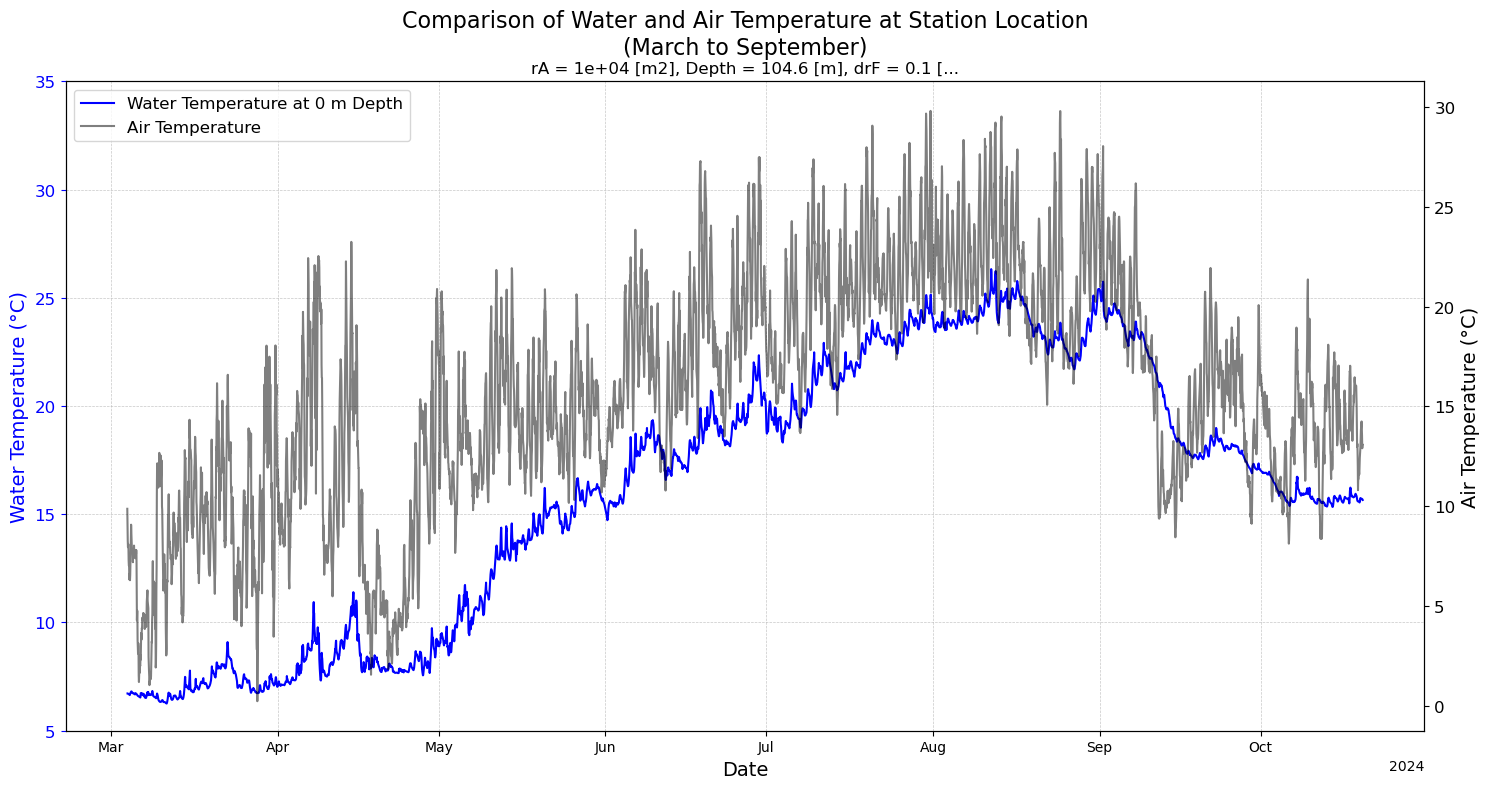

In [8]:
import matplotlib.dates as mdates
import pandas as pd


plt.close('all')
fig, ax1 = plt.subplots(figsize=(15, 8))

# Plot water temperature on primary y-axis
for i in range(1):
    ds_to_plot[var2].sel(XC=xc_mitgcm_station, YC=yc_mitgcm_station, Z=-i*5, method='nearest').plot(
        ax=ax1, color="blue", label=f"Water Temperature at {i*5} m Depth")

# Primary y-axis (Water Temperature)
ax1.set_ylabel('Water Temperature (°C)', fontsize=14, color='blue')
ax1.tick_params(axis='y', colors='blue', labelsize=12)
ax1.set_ylim(5, 35)
ax1.grid(True, which='both', linewidth=0.5, linestyle='--', alpha=0.7)

# Secondary y-axis (Air Temperature)
ax2 = ax1.twinx()
ax2.plot(date_list, bin_array[:, 100, 75] - 273.15, linestyle='-', color='black', alpha=0.5, label='Air Temperature')

ax2.set_ylabel('Air Temperature (°C)', fontsize=14, color='black')
ax2.tick_params(axis='y', labelcolor='black', labelsize=12)

# X-axis formatting (Optional: use if x-axis is datetime)
ax1.set_xlabel('Date', fontsize=14)
if isinstance(date_list[0], (np.datetime64, pd.Timestamp)):
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    fig.autofmt_xdate()

# Combine and place legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12)

# Title
plt.title('Comparison of Water and Air Temperature at Station Location\n(March to September)', fontsize=16, pad=20)

# Save (optional)
# plt.savefig(f"{lake_name}_Temp_air_vs_water_Mar_Sept.png", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [49]:
def plot_map(i_time: int, i_depth: int):
    plt.ioff()
    plt.close()
    fig, ax = plt.subplots(figsize=(15,5))
    
    T_plot = ds_to_plot['time'].values[i_time]
    Z_plot = ds_to_plot['Z'].values[i_depth]
    xr_plot = ds_to_plot['THETA'].sel(time=T_plot, Z=Z_plot)
    xr_plot = xr_plot.where(xr_plot != 0, np.nan)
    xr_plot.plot(cmap='jet', vmin=5, vmax=27)
    plt.axis('equal')
    
    subsetting_factor = 5
    X_trimmed = ds_to_plot['XC'][::subsetting_factor]
    Y_trimmed = ds_to_plot['YC'][::subsetting_factor]
    U_trimmed = ds_to_plot['UVEL'].sel(time=T_plot, Z=Z_plot)[:,1:][::subsetting_factor,::subsetting_factor]
    V_trimmed = ds_to_plot['VVEL'].sel(time=T_plot, Z=Z_plot)[1:,:][::subsetting_factor,::subsetting_factor]
    
    U_trimmed = U_trimmed.where(U_trimmed != 0, np.nan)
    V_trimmed = V_trimmed.where(V_trimmed != 0, np.nan)
    plt.quiver(X_trimmed, Y_trimmed, U_trimmed, V_trimmed, scale=8)
    
    #plt.xlim(37500,42500)
    #plt.ylim(19500,24500)
    
    plt.text(0.02, 0.98, f'{np.datetime_as_string(T_plot, unit="s").replace("T", " ")}', transform=plt.gca().transAxes, ha='left', va='top')
    plt.text(0.02, 0.9, f'Z={Z_plot}m', transform=plt.gca().transAxes, ha='left', va='top')
    plt.title('')
    
    # Remove axis, ticks, labels, and title
    #ax.set_xticks([])
    #ax.set_yticks([])
    #ax.set_xlabel("")
    #ax.set_ylabel("")
    #ax.set_title("")
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    
    return plt.gcf()

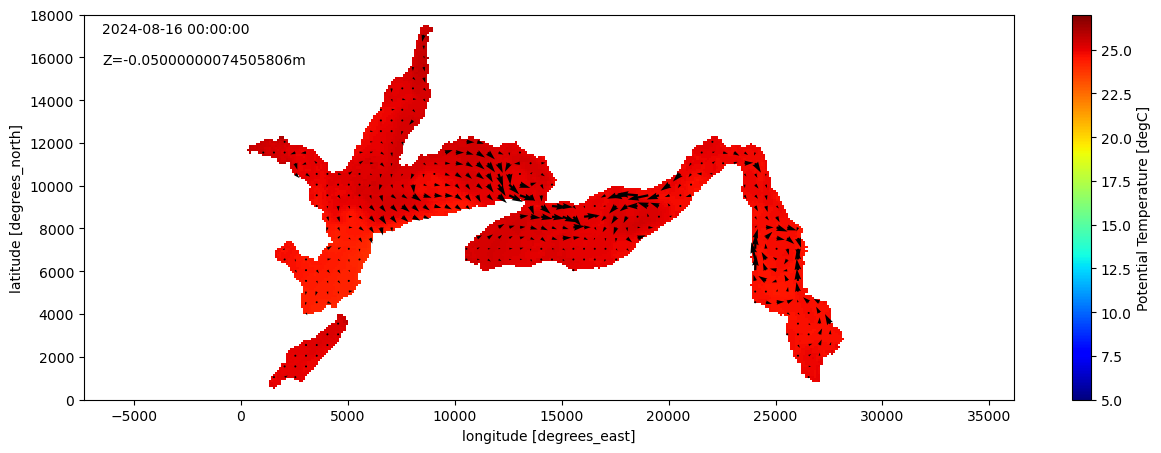

In [50]:
i_time = 3959
i_depth = 0
plot_map(i_time, i_depth)

In [23]:
sta_name = 'lower_zurich'
with open(os.path.join('/home/rasmusso@eawag.wroot.emp-eaw.ch/Documents/plot_results/config_points.json'), 'r') as file:
    config_points = json.load(file)[sta_name]
    
xc_mitgcm_station = config_points['xc_mitgcm_200m']
yc_mitgcm_station = config_points['yc_mitgcm_200m']

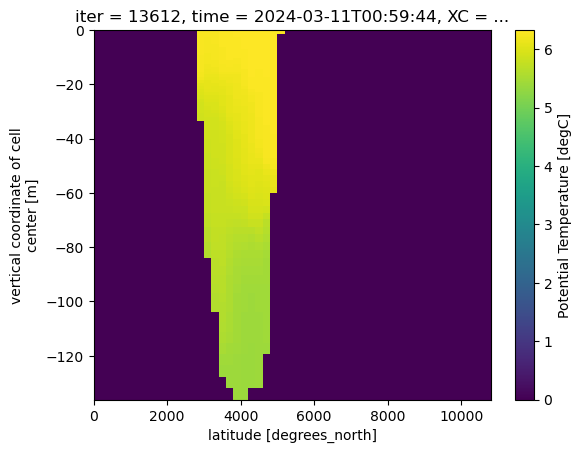

In [26]:
ds_to_plot['THETA'].isel(time=i_time).sel(XC=xc_mitgcm_station, method='nearest').plot()
plt.show()

# Create video

In [5]:
make_video = True
output_video_folder = r'/home/rasmusso@eawag.wroot.emp-eaw.ch/Documents/plot_results/output_plots/videos'
print(len(ds_to_plot['time'].values))

5520


In [52]:
import os

# Ensure the output directory exists
os.makedirs(output_video_folder, exist_ok=True)

if make_video != True:
    exit

for i in range(2855,3599):
    fig = plot_map(i,0)
    filepath = os.path.join(output_video_folder, f'temperature_{i}.png')
    print(f"saving: {filepath}")
    fig.savefig(filepath)
    plt.close()

saving: /home/rasmusso@eawag.wroot.emp-eaw.ch/Documents/plot_results/output_plots/videos/temperature_2855.png
saving: /home/rasmusso@eawag.wroot.emp-eaw.ch/Documents/plot_results/output_plots/videos/temperature_2856.png
saving: /home/rasmusso@eawag.wroot.emp-eaw.ch/Documents/plot_results/output_plots/videos/temperature_2857.png
saving: /home/rasmusso@eawag.wroot.emp-eaw.ch/Documents/plot_results/output_plots/videos/temperature_2858.png
saving: /home/rasmusso@eawag.wroot.emp-eaw.ch/Documents/plot_results/output_plots/videos/temperature_2859.png
saving: /home/rasmusso@eawag.wroot.emp-eaw.ch/Documents/plot_results/output_plots/videos/temperature_2860.png
saving: /home/rasmusso@eawag.wroot.emp-eaw.ch/Documents/plot_results/output_plots/videos/temperature_2861.png
saving: /home/rasmusso@eawag.wroot.emp-eaw.ch/Documents/plot_results/output_plots/videos/temperature_2862.png
saving: /home/rasmusso@eawag.wroot.emp-eaw.ch/Documents/plot_results/output_plots/videos/temperature_2863.png
saving: /h

In [23]:
if make_video != True:
    exit
import moviepy    
from moviepy.editor import ImageSequenceClip
import glob
import os

video_name = 'LU_current_video.mp4'
fps = 10

# Get all images
images = glob.glob(f"{output_video_folder}/*.png")
images = sorted(images)
# Create a clip from the images
clip = ImageSequenceClip(images, fps=fps)
clip.write_videofile(os.path.join(output_video_folder, video_name), fps=fps, codec="libx264", audio=False)
print("Video created successfully.")

Moviepy - Building video /home/rasmusso@eawag.wroot.emp-eaw.ch/Documents/plot_results/output_plots/videos/LU_current_video.mp4.
Moviepy - Writing video /home/rasmusso@eawag.wroot.emp-eaw.ch/Documents/plot_results/output_plots/videos/LU_current_video.mp4



Moviepy - Done !
Moviepy - video ready /home/rasmusso@eawag.wroot.emp-eaw.ch/Documents/plot_results/output_plots/videos/LU_current_video.mp4
Video created successfully.


In [21]:
images = sorted(images)